# Tutorial - Time Series Forecasting - Adaboost Regressor

The goal is to forecast time series with the Adaboost Regressor Approach using tsfresh for features extraction. 1) JetRail Commuter, 2) Air Passengers, 3) Function Adaboost with Air Passengers, and 5) Function Adaboost with Wine Sales.

In [198]:
%matplotlib inline

In [199]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [200]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from tqdm import tqdm

In [201]:
# Load File
url = 'https://raw.githubusercontent.com/tristanga/Machine-Learning/master/Data/JetRail%20Avg%20Hourly%20Traffic%20Data%20-%202012-2013.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
Datetime    494 non-null object
ID          494 non-null float64
Count       494 non-null float64
dtypes: float64(2), object(1)
memory usage: 11.7+ KB


In [202]:
df.Datetime = pd.to_datetime(df.Datetime,format='%Y-%m-%d %H:%M') 
df.index = df.Datetime

# Boosting Algorithms - Adaboost Regressor Approach with JetRail 

An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

In [203]:
# Use Forecasting frame from tsfresh for rolling forecast training
df_shift, y = make_forecasting_frame(df["Count"], kind="Count", max_timeshift=20, rolling_direction=1)

In [204]:
# Extracting features from df_shift
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.75s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__ch

 'value__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


(493, 794)
(493, 347)


In [205]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2012-08-27,23.472222,0.500000,-1.000000,-1.000000,0.000000,46.75,1.0,2.083333,40.941667,0.256859,...,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.062500,0.0,3.666667
2012-08-28,30.145833,1.583333,-0.394685,-0.394685,0.099821,46.75,1.0,2.083333,40.941667,0.256859,...,1.0,1.0,1.0,1.0,-12.298611,0.000000,0.0,0.195988,0.0,2.583333
2012-08-29,35.986111,1.750000,-0.429472,-0.460993,0.187446,46.75,1.0,2.083333,40.941667,0.256859,...,1.0,1.0,1.0,1.0,-15.971354,0.000000,0.0,0.244792,0.0,2.416667
2012-08-30,42.236111,1.833333,-0.393790,-0.487490,0.209361,46.75,1.0,2.083333,40.941667,0.256859,...,1.0,1.0,1.0,1.0,-10.988812,-9.759259,0.0,0.229444,0.0,2.500000
2012-08-31,51.743056,2.416667,-0.159395,0.080000,0.192383,46.75,1.0,2.083333,3.666667,-1.000000,...,1.0,1.0,1.0,1.0,-5.949942,-9.637442,0.0,0.197724,0.0,3.083333


In [206]:
import math
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

train_size=math.floor(0.7*len(y)) #(70% Dataset)

isp = train_size   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [00:27<00:00,  5.45it/s]


In [207]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()
train_size=math.floor(0.7*len(y))
test = ys[isp:]
train = ys[:isp]

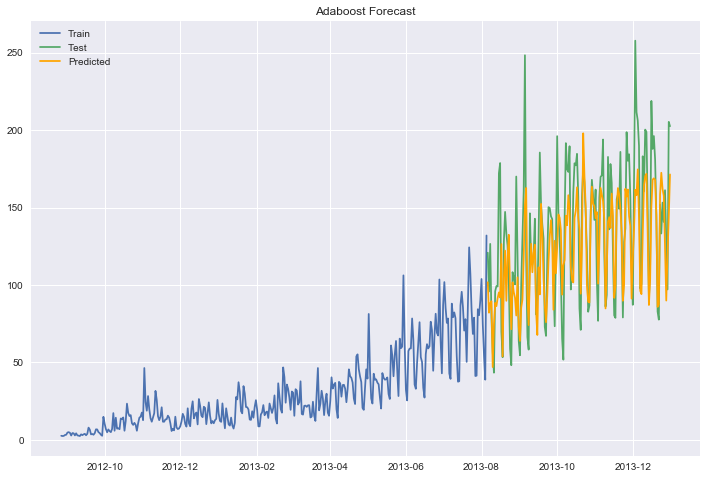

In [208]:
#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['true'], label='Train')
plt.plot(test.index, test['true'], label='Test')
plt.plot(test.index, test['pred'], label='Predicted', color = 'orange')
plt.legend(loc='best')
plt.title("Adaboost Forecast")
plt.show()

In [209]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("RMSE ada: ", round(sqrt(mean_squared_error(test.pred, test.true)),2))
print("MAE ada: ", round(mean_absolute_error(test.pred, test.true),2))

RMSE ada:  32.33
MAE ada:  24.77


# Importance of features

In [210]:
# Inspect the relevance of the extracted features
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
feature_last_value                                                   0.152804
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20        0.108930
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5         0.106883
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_5        0.080408
value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2    0.075655
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_5        0.070128
value__fft_coefficient__coeff_3__attr_"abs"                          0.068522
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5         0.045306
value__fft_coefficient__coeff_3__attr_"real"                         0.041474
value__quantile__q_0.1                                               0.020520
dtype: float64

# Boosting Algorithms - Adaboost Regressor  Approach with Air Passagers 

In [211]:
# Subsetting
url = 'https://raw.githubusercontent.com/tristanga/Machine-Learning/master/Data/International%20Airline%20Passengers.csv'
df = pd.read_csv(url, sep =";")
df.info()
df.Month = pd.to_datetime(df.Month,format='%Y-%m')
df.index = df.Month
#df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month         144 non-null object
Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [212]:
# Use Forecasting frame from tsfresh for rolling forecast training
df_shift, y = make_forecasting_frame(df["Passengers"], kind="Passengers", max_timeshift=12, rolling_direction=1)

In [213]:
# Extracting features from df_shift
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__ch

 'value__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


(143, 794)
(143, 314)


In [214]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
1949-03-01,26468.0,6.0,-1.000000,-1.000000,0.000000,302.0,-1.0,-33.0,275.083333,-0.074027,...,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,9.000000,1.0,118.0
1949-04-01,43892.0,20.0,-0.724684,-0.724684,0.454344,302.0,-1.0,-33.0,275.083333,-0.074027,...,1.0,1.0,1.0,1.0,575840.000000,0.0,0.0,70.222222,1.0,132.0
1949-05-01,60533.0,23.0,-0.558727,-0.982873,0.394764,302.0,-1.0,-33.0,275.083333,-0.074027,...,1.0,1.0,1.0,1.0,467242.000000,0.0,0.0,65.687500,1.0,129.0
1949-06-01,75174.0,31.0,-0.234304,-0.158654,0.269117,302.0,-1.0,-33.0,275.083333,-0.074027,...,1.0,1.0,1.0,1.0,191825.666667,276804.0,0.0,53.040000,1.0,121.0
1949-07-01,93399.0,45.0,-0.456352,-0.184906,0.623900,302.0,-1.0,-33.0,132.000000,1.000000,...,1.0,1.0,1.0,1.0,191785.250000,415816.5,0.0,66.250000,1.0,135.0


In [215]:
import math
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

train_size=math.floor(0.7*len(y)) #(70% Dataset)

isp = train_size   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 18.35it/s]


In [216]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()
train_size=math.floor(0.7*len(y))
test = ys[isp:]
train = ys[:isp]

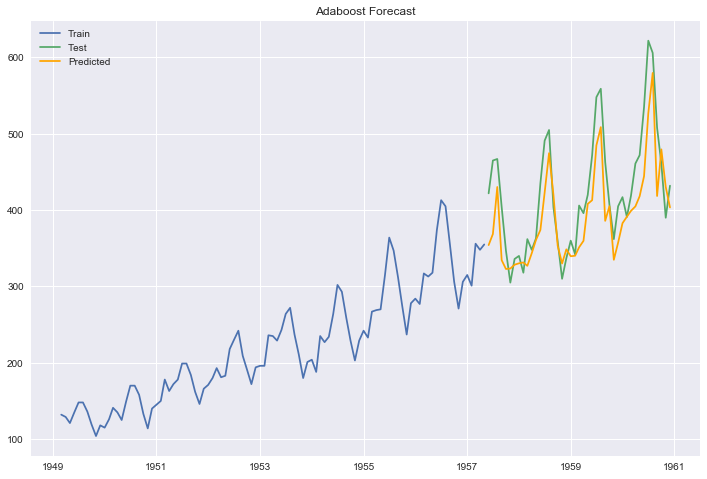

In [217]:
#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['true'], label='Train')
plt.plot(test.index, test['true'], label='Test')
plt.plot(test.index, test['pred'], label='Predicted', color = 'orange')
plt.legend(loc='best')
plt.title("Adaboost Forecast")
plt.show()

In [218]:
print("RMSE ada: ", round(sqrt(mean_squared_error(test.pred, test.true)),2))
print("MAE ada: ", round(mean_absolute_error(test.pred, test.true),2))

RMSE ada:  46.46
MAE ada:  37.26


# Function Adaboost Approach with variables

In [219]:
def ADABOOST_forecasting(mydf,colval,split,rolling):
    import warnings
    warnings.filterwarnings('ignore')
    global y_hat, train, test
    df_shift, y = make_forecasting_frame(df[colval], kind=colval, max_timeshift=rolling, rolling_direction=1)
    X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                         show_warnings=False)
    X = X.loc[:, X.apply(pd.Series.nunique) != 1]
    X["feature_last_value"] = y.shift(1)
    X = X.iloc[1:, ]
    y = y.iloc[1: ]
    ada = AdaBoostRegressor(n_estimators=10)
    y_pred = [np.NaN] * len(y)
    train_size=math.floor(split*len(y))
    isp = train_size 
    assert isp > 0
    for i in tqdm(range(isp, len(y))):
        ada.fit(X.iloc[:i], y[:i])
        y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    y_pred = pd.Series(data=y_pred, index=y.index)
    ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})
    ys.index = pd.to_datetime(ys.index)
    train_size=math.floor(split*len(y))
    test = ys[isp:]
    train = ys[:isp]
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train['true'], label='Train')
    plt.plot(test.index, test['true'], label='Test')
    plt.plot(test.index, test['pred'], label='Predicted', color = 'orange')
    plt.legend(loc='best')
    plt.title("Adaboost Forecast")
    plt.show()
    print("RMSE ada: ", round(sqrt(mean_squared_error(test.pred, test.true)),2))
    print("MAE ada: ", round(mean_absolute_error(test.pred, test.true),2))

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__ch

 'value__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.
100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 18.49it/s]


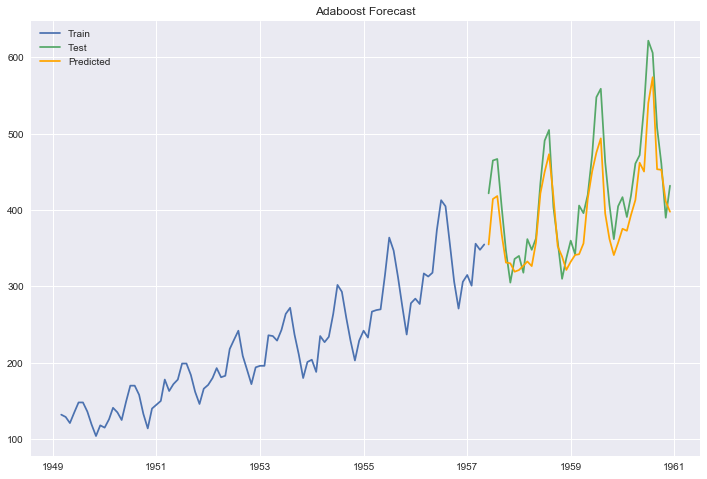

RMSE ada:  39.75
MAE ada:  33.23


In [220]:
ADABOOST_forecasting(df,'Passengers',0.7, 12)

# Testing Function Autoregression (AR) Approach with Wine Dataset 

In [221]:
url = 'https://raw.githubusercontent.com/tristanga/Data-Cleaning/master/Converting%20Time%20Series/Wine_Sales_R_Dataset.csv'
df = pd.read_csv(url)
df.info()
df.Date = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df.Date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
Date     176 non-null object
Sales    176 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__ch

 'value__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.
100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:03<00:00, 14.82it/s]


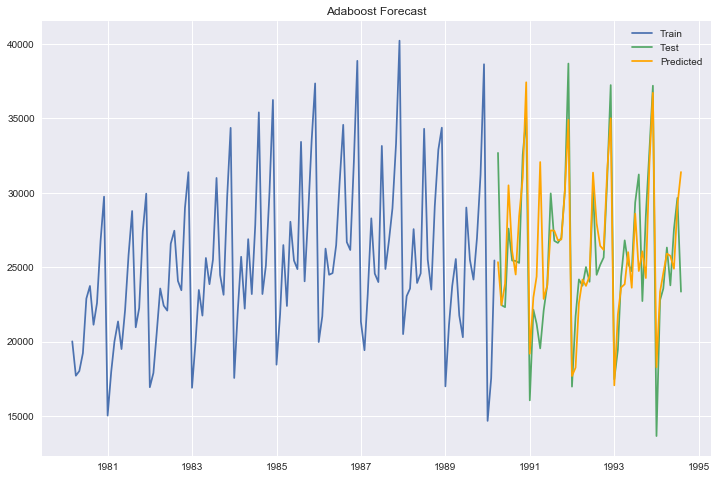

RMSE ada:  3096.86
MAE ada:  2063.32


In [222]:
ADABOOST_forecasting(df,'Sales',0.7, 12)